In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy.calc as mpcalc
from metpy.interpolate import cross_section
import xwrf 

from metpy.plots import USCOUNTIES
import pickle


In [13]:
init = pd.Timestamp(2022,12,21,18)
fcst_end = init + pd.Timedelta(hours=10)

### time to plot
output_time = pd.Timestamp(2022,12,21,23,40)
#output_time = pd.Timestamp(2022,12,21,23,30)

# wrf filename matching this time
wrf_filename = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+output_time.strftime("%Y-%m-%d_%H:%M:%S")

wrf_filename

'/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:40:00'

In [14]:
wrfin = xr.open_dataset(wrf_filename).xwrf.postprocess()

In [15]:
wrfin

<xarray.Dataset>
Dimensions:                    (Time: 1, y: 790, x: 670, soil_layers_stag: 4,
                                z: 85, x_stag: 671, y_stag: 791, z_stag: 86,
                                pft_fraction_stag: 17, seed_dim_stag: 34)
Coordinates: (12/15)
    XLAT                       (y, x) float32 38.01 38.01 38.01 ... 42.23 42.23
    XLONG                      (y, x) float32 -106.4 -106.4 ... -101.6 -101.6
    XTIME                      (Time) timedelta64[ns] 05:40:00
    XLAT_U                     (y, x_stag) float32 38.01 38.01 ... 42.23 42.23
    XLONG_U                    (y, x_stag) float32 -106.4 -106.4 ... -101.6
    XLAT_V                     (y_stag, x) float32 38.01 38.01 ... 42.23 42.23
    ...                         ...
  * z_stag                     (z_stag) float32 1.0 0.9938 ... 0.002003 0.0
  * Time                       (Time) datetime64[ns] 2022-12-21T23:40:00
  * x                          (x) float64 -1.227e+05 -1.221e+05 ... 2.787e+05
  * y                          (y) float64 -3.312e+05 -3.306e+05 ... 1.422e+05
  * y_stag                     (y_stag) float64 -3.315e+05 ... 1.425e+05
  * x_stag                     (x_stag) float64 -1.23e+05 ... 2.79e+05
Dimensions without coordinates: soil_layers_stag, pft_fraction_stag,
                                seed_dim_stag
Data variables: (12/206)
    Times                      (Time) |S19 b'2022-12-21_23:40:00'
    LU_INDEX                   (Time, y, x) float32 ...
    ZS                         (Time, soil_layers_stag) float32 ...
    DZS                        (Time, soil_layers_stag) float32 ...
    VAR_SSO                    (Time, y, x) float32 ...
    U                          (Time, z, y, x_stag) float32 ...
    ...                         ...
    air_pressure               (Time, z, y, x) float32 6.915e+04 ... 5.096e+03
    geopotential               (Time, z_stag, y, x) float32 3.016e+04 ... 1.9...
    geopotential_height        (Time, z_stag, y, x) float32 3.074e+03 ... 2.0...
    wind_east                  (Time, z, y, x) float32 8.419 8.579 ... 26.06
    wind_north                 (Time, z, y, x) float32 -2.122 -2.021 ... -4.054
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
Attributes: (12/131)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      2022-12-21_18:00:00
    SIMULATION_START_DATE:           2022-12-21_18:00:00
    WEST-EAST_GRID_DIMENSION:        671
    SOUTH-NORTH_GRID_DIMENSION:      791
    BOTTOM-TOP_GRID_DIMENSION:       86
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [16]:
subset_vars = ['HGT','air_potential_temperature','geopotential_height','air_pressure','T2','U10','V10','W',
              'wrf_projection','wind_east','wind_north']
wrf_subset = wrfin[subset_vars].squeeze().xwrf.destagger()

wrf_subset['t2c'] = wrf_subset['T2'].metpy.convert_units('degC') 
wrf_subset['wspd'] = mpcalc.wind_speed(wrf_subset.wind_east, wrf_subset.wind_north)

In [17]:
wrf_subset

<xarray.Dataset>
Dimensions:                    (y: 790, x: 670, z: 85, z_stag: 86)
Coordinates:
    XLONG                      (y, x) float32 -106.4 -106.4 ... -101.6 -101.6
    XTIME                      timedelta64[ns] 05:40:00
    CLAT                       (y, x) float32 38.01 38.01 38.01 ... 42.23 42.23
    Time                       datetime64[ns] 2022-12-21T23:40:00
  * x                          (x) float64 -1.227e+05 -1.221e+05 ... 2.787e+05
  * y                          (y) float64 -3.312e+05 -3.306e+05 ... 1.422e+05
    XLAT                       (y, x) float32 38.01 38.01 38.01 ... 42.23 42.23
  * z                          (z) float32 0.9969 0.9899 ... 0.003043 0.001002
  * z_stag                     (z_stag) float32 1.0 0.9938 ... 0.002003 0.0
Data variables: (12/13)
    HGT                        (y, x) float32 ...
    air_potential_temperature  (z, y, x) float32 298.0 298.1 ... 489.2 489.2
    geopotential_height        (z, y, x) float32 3.097e+03 ... 1.998e+04
    air_pressure               (z, y, x) float32 6.915e+04 ... 5.096e+03
    T2                         (y, x) float32 267.8 267.9 267.9 ... 247.5 247.5
    U10                        (y, x) float32 ...
    ...                         ...
    W                          (z, y, x) float32 0.06296 0.1121 ... -0.01881
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
    wind_east                  (z, y, x) float32 8.419 8.579 8.86 ... 26.1 26.06
    wind_north                 (z, y, x) float32 -2.122 -2.021 ... -4.206 -4.054
    t2c                        (y, x) float32 <Quantity([[ -5.3007507  -5.275...
    wspd                       (z, y, x) float32 <Quantity([[[ 8.682559   8.8...
Attributes: (12/131)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      2022-12-21_18:00:00
    SIMULATION_START_DATE:           2022-12-21_18:00:00
    WEST-EAST_GRID_DIMENSION:        671
    SOUTH-NORTH_GRID_DIMENSION:      791
    BOTTOM-TOP_GRID_DIMENSION:       86
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [18]:
#### assign metpy CRS using the metadata
wrf_subset = wrf_subset.metpy.assign_crs(
    grid_mapping_name=wrf_subset.wrf_projection.attrs['grid_mapping_name'],
    latitude_of_projection_origin=wrf_subset.wrf_projection.attrs['latitude_of_projection_origin'],
    longitude_of_central_meridian=wrf_subset.wrf_projection.attrs['longitude_of_central_meridian'],
    standard_parallel=wrf_subset.wrf_projection.attrs['standard_parallel'],
    earth_radius=wrf_subset.wrf_projection.attrs['semi_major_axis']
)

### Define the lat/lon endpoints of our cross-section

In [19]:
### define cross-section line

### 2300
### weld county
start = (39.97,-104.88)
end = (40.58, -104.30)

### farther south
#start = (39.4, -104.25)
#end = (40.25, -103.6)

### Use MetPy's cross-section method to calculate the quantities along our specified line

In [20]:
cross = cross_section(wrf_subset, start, end).set_coords(('XLAT', 'XLONG'))
### expand the longitude array dims to allow for plotting of hybrid data
cross['longitude2d'] = cross.XLONG.expand_dims({'sigma':cross.z.shape[0]})

/home/rschumac/miniconda3/envs/ats735/lib/python3.8/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "HGT".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/home/rschumac/miniconda3/envs/ats735/lib/python3.8/site-packages/metpy/xarray.py:355: UserWarning: More than one latitude coordinate present for variable "HGT".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


In [21]:
cross

Magnitude,[4.467535839965792 4.4243759621719 4.407247309882373 4.471646120057248 4.8964777935497406 5.078007713758053 5.29217094575272 4.487669753669832 5.268702124194244 4.9924225546778045 4.977705201744824 4.686682377557613 3.833924520126579 -2.311538738087519 -7.94845371987243 -7.591307976503041 -8.032504436148912 -8.106202106242707 -8.504798655484546 -9.121682295535237 -9.416425337737147 -9.90648313441108 -10.073034225084184 -10.200096462627148 -10.438556804071604 -10.49967997145354 -10.262827027137615 -10.287353610989873 -10.065588510585638 -9.728515535691457 -9.824734669512075 -10.245972796060162 -10.483040537326811 -10.474870005040716 -10.324944062288385 -10.384802180234443 -10.60258541802948 -10.61810310529328 -10.748934613370125 -10.62112105719957 -10.514622228573241 -10.852491752154153 -11.075435171393465 -10.944029348834787 -11.35566663331031 -11.86332579779803 -12.145199270964975 -12.295601338836287 -12.29079142990015 -12.083352987380358 -11.961086023734971 -12.247389952484248 -12.403095941254666 -12.280503722566063 -12.238156295870748 -12.270302113205105 -12.359497527807207 -12.511012121975428 -12.687585069170972 -12.776232596465439 -12.954398414343856 -13.403403142884208 -13.748493257284991 -13.947605062357411 -13.9569296525829 -14.014328393353738 -14.006164750036064 -13.933345515053167 -13.690130350275115 -13.538321702488652 -13.84511031472056 -14.20193437651879 -14.563107352447824 -14.51813854124919 -14.57678602726417 -14.634708762080574 -14.696041811271687 -14.538675098523417 -14.611173932503231 -14.59701141565742 -14.554537775083208 -14.688585413888365 -14.34028743904137 -14.3337566778436 -14.486550669436214 -14.65943788757159 -14.840190611799832 -14.955181751958525 -14.989300409935714 -14.939163980307988 -14.850368723694308 -14.803235399925455 -14.878284931441353 -15.013123150907255 -15.081741580292356 -14.907598018402954 -15.423239626100075 -15.448061943506127 -15.403388551346165 -15.228839391766131]
Units,degree_Celsius
Magnitude,[[10.14353184193575 10.188953891941956 10.304207663215296 ... 10.545127181284382 10.74324162254405 11.1398081340192] [12.3457487991754 12.445600189767589 12.7740289742565 ... 13.033819077630945 13.194417192649048 13.522201936863139] [14.523941553402514 14.343366718597434 14.466609105216504 ... 14.463439816931638 14.642019293283909 14.994852165391508] ... [20.435835372130438 20.70119962557724 20.963956221923915 ... 22.653238435058338 22.645819113474154 22.672141629796577] [22.600408399984154 22.84845633351067 23.091339727171935 ... 23.77782029567367 23.732673446581614 23.697843109204914] [24.292994318601764 24.53298291040865 24.77485014508052 ... 23.90031533254782 23.882212591341094 23.918440647196235]]
Units,meter/second


### first plot a map of 2-m temp with the cross-section location

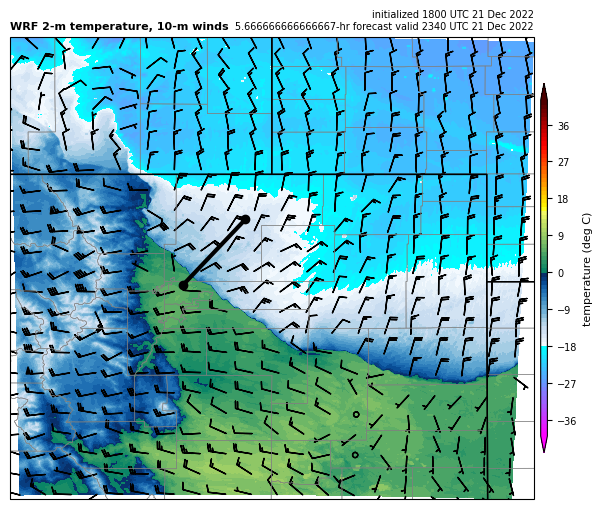

In [22]:
## get time and forecast lead info
vtime = pd.to_datetime(wrf_subset.Time.values)
#lead = int((vtime - init).total_seconds() // 3600)
lead = (vtime - init).total_seconds() / 3600

# Set Projection of Plot
fig = plt.figure(figsize=(9,6))
#add_metpy_logo(fig, 1775, 170, size='large')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set plot bounds -- or just comment this out if wanting to plot the full domain
#ax.set_extent((-110, -100, 37., 42.5))
#ax.set_extent((-88.5, -80.5, 35,39.25))

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))

### temperature contour levels & color scale
#clevs = np.arange(-40,110,2)  ### range of temperatures
clevs = np.arange(-40, 43, 1)

#### read in colormap
#fp = open('/Users/rschumac/research/real_time/functions_rtwx/sfc_temp_cmap.pkl', 'rb')
fp = open('sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()

cf = ax.contourf(wrf_subset.XLONG, wrf_subset.XLAT,
                 wrf_subset.t2c,
                 clevs,
                 cmap=sfc_temp_cmap, 
                 #alpha=0.7,
                 extend='both',
                 transform_first=True,
                 transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                  shrink=0.8, aspect=50)
cb.set_label('temperature (deg C)', fontsize=8)
cb.ax.locator_params(nbins=20)
cb.ax.tick_params(labelsize=7)

# Add the 10-m wind barbs, only plotting every 15th data point.
wind_slice = (slice(None, None, 35), slice(None,None,35))
plt.barbs(wrf_subset.XLONG[wind_slice].values, wrf_subset.XLAT[wind_slice].values,
          wrf_subset.U10[wind_slice].metpy.convert_units('kt').values, 
          wrf_subset.V10[wind_slice].metpy.convert_units('kt').values,
          transform=ccrs.PlateCarree(), length=5)

ax.plot([start[1], end[1]],
            [start[0],end[0]], color="black", marker="o",
            transform=ccrs.PlateCarree(), zorder=3, linewidth=3)

## add location of tslist points
#lat_points = [44.046,44.617,45.084,45.022,45.521,45.683,46.045] 
#lon_points = [-103.060,-102.900,-102.266,-101.836,-100.512,-100.320,-99.802]
#names = ['rap','sd1','sd2','sd3','sd4','sd5','sd6']
#nums = [0,1,2,3,4,5,6]
#ax.scatter(lon_points,lat_points,15,
#     color='magenta', marker='o', 
#     transform=ccrs.PlateCarree())

# add titles
plt.title("WRF 2-m temperature, 10-m winds",
          loc='left', weight='bold', fontsize=8)
plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(lead)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
      loc='right', fontsize=7)

plt.show()

#fig.savefig("t2m_xsecline_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
#           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.close('all')



### now plot the cross-section

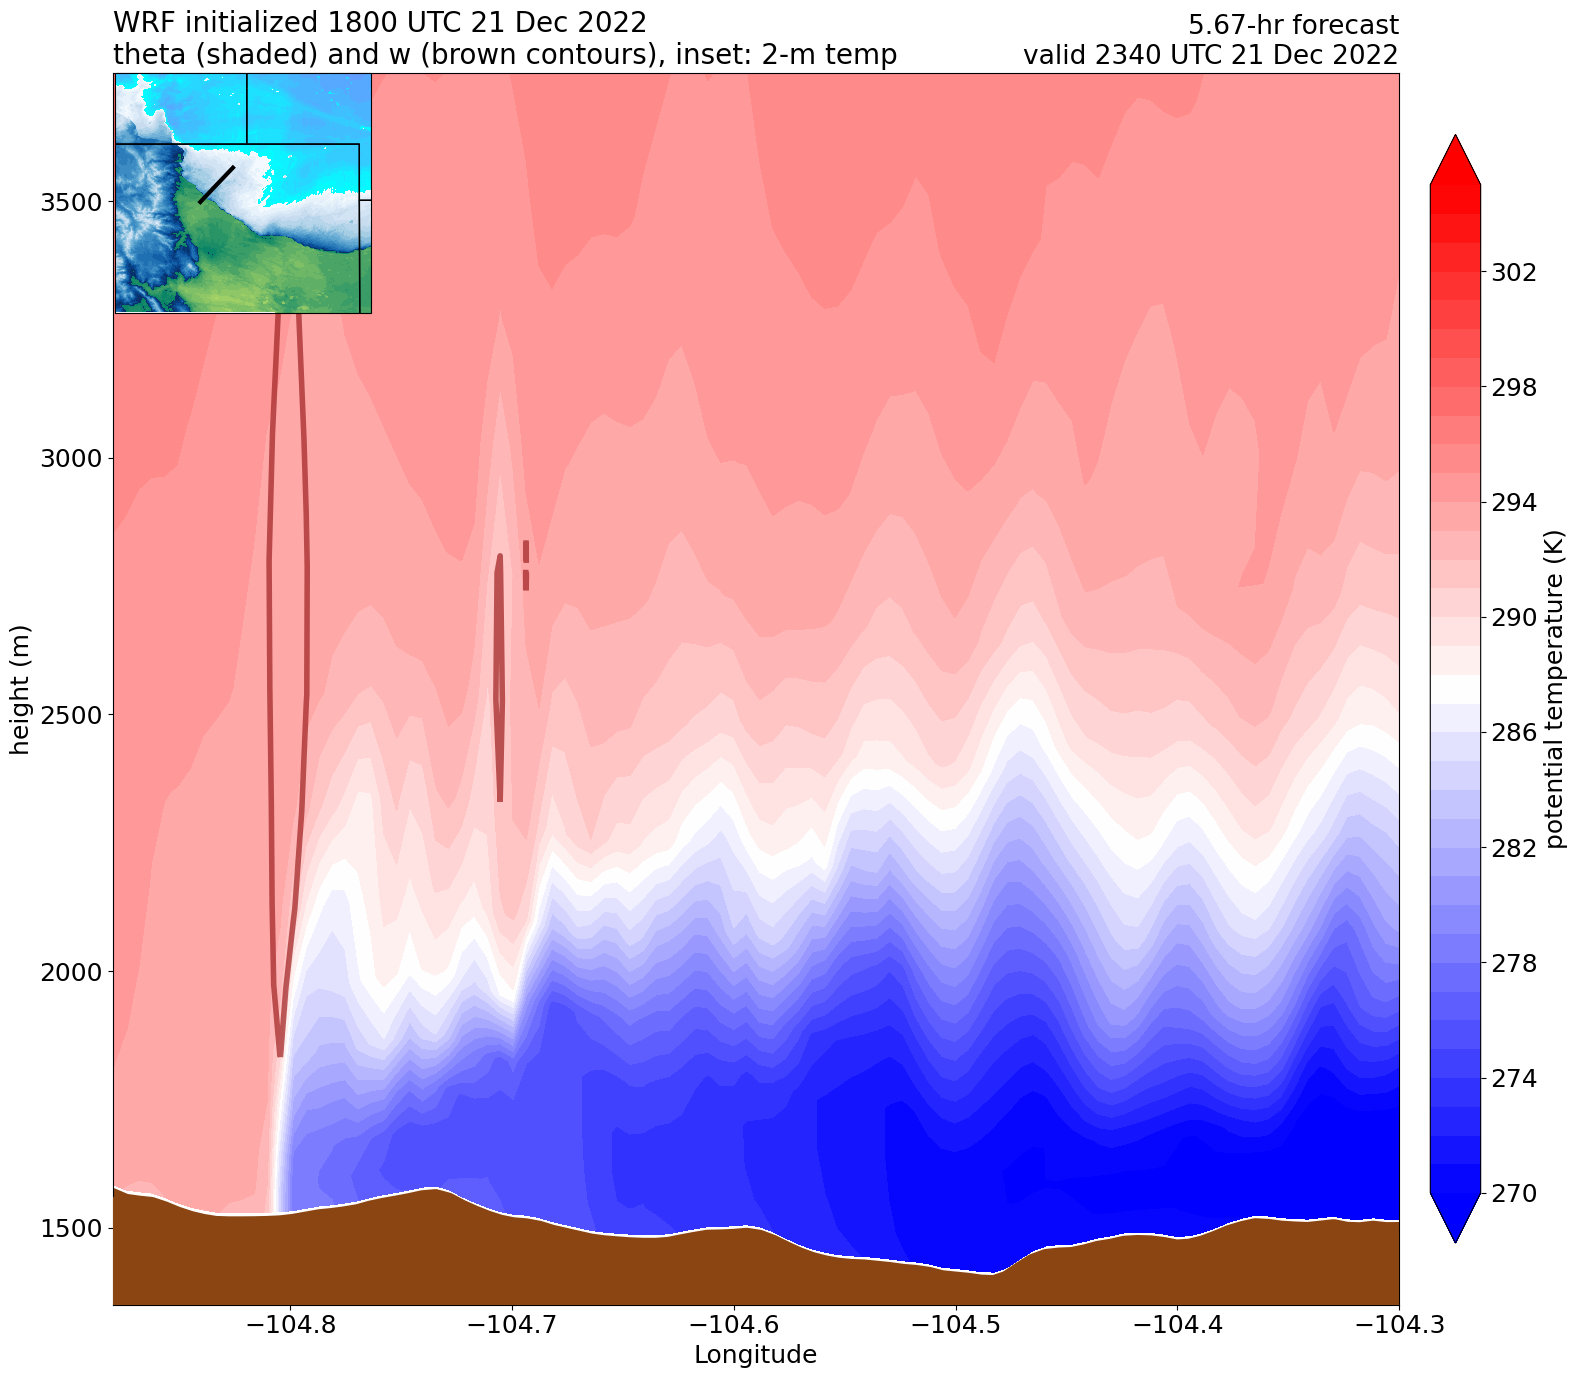

In [23]:
# Define the figure object and primary axes
fig = plt.figure(figsize=(20,16))
ax = plt.axes()

## color fill theta
theta_contour = ax.contourf(cross['longitude2d'], cross['geopotential_height'], 
                            cross['air_potential_temperature'],
                          levels=np.arange(270,306,1), 
                            #cmap='RdBu_r',
                            cmap='bwr', 
                            extend='both')

# Add the color bar
cb1 = fig.colorbar(theta_contour, ax=ax, shrink=.9, pad=0.02)
cb1.set_label('potential temperature (K)', fontsize=18)
cb1.ax.tick_params(labelsize=18)

## plot vertical velocity
www_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], cross['W'],
                         #  levels=[-10,-7.5,-5,-2.5,2.5,5,7.5,10], 
                         levels=[-12,-9,-6,-3,3,6,9,12],
                         colors='brown', alpha=0.75, linewidths=4)

#www_contour.clabel(www_contour.levels[1::2], fontsize=12, colors='k', inline=1,
#                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

### wind speed contours
#wspd_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], cross['wspd'],
#                         levels=[15,20,25,30,35,40],
#                         colors='black', linewidths=2)

### try pressure contours
#prs_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], 
#                         cross['air_pressure'].metpy.convert_units('hPa'),
#                         np.arange(820,880,1),
#                         colors='black', alpha=0.75, linewidths=2)
#prs_contour.clabel(prs_contour.levels[1::2], fontsize=12, colors='k', inline=1,
#                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)


## plot terrain height
ax.plot(cross['XLONG'], cross['HGT'], color='saddlebrown', lw=12)
ax.fill_between(cross['XLONG'], cross['HGT'], 0,
                facecolor='saddlebrown',
               interpolate=True, zorder=10)

# Set y-axis limit
ax.set_ylim(1350,3750)
## Set the x-axis and  y-axis labels
ax.set_xlabel("Longitude", fontsize=18)
ax.set_ylabel("height (m)", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

#### now add an inset in the upper left
ax_inset = fig.add_axes([0.115, 0.73, 0.15, 0.15], projection=ccrs.PlateCarree())
ax_inset.set_extent([-106.4,-101.85,38.0,42.27])  

## inset contours
ax_inset.contourf(wrf_subset.XLONG, wrf_subset.XLAT,
                 wrf_subset.t2c,
                 clevs,
                 cmap=sfc_temp_cmap, 
                 #alpha=0.7,
                 extend='both',
                 transform_first=True,
                 transform=ccrs.PlateCarree())

# Plot the path of the cross section
ax_inset.plot(cross['XLONG'], cross['XLAT'], c='k', zorder=10, 
        linewidth=3, transform=ccrs.PlateCarree())

# Add geographic features
ax_inset.coastlines('50m', edgecolor='black', linewidth=0.75)
ax_inset.add_feature(cfeature.STATES, linewidth=1)

# Set the titles and axes labels
ax_inset.set_title('')


# Plot Titles
ax.set_title("WRF initialized "+init.strftime("%H%M UTC %d %b %Y")+"\ntheta (shaded) and w (brown contours), inset: 2-m temp",
          loc='left', fontsize=20)
ax.set_title(str(np.round(lead,2))+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=19)

fig.savefig("xsec_theta_www_wrf_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.show()

plt.close('all')


In [124]:
print(cross.XLONG[0].item(), cross.XLAT[0].item())
print(cross.XLONG[-1].item(), cross.XLAT[-1].item())

-104.87999889797413 39.969996023861405
-104.29999681485127 40.579998603947054
